In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

# Load the dataset
data = pd.read_csv('amazon.csv')

# Drop rows with missing values
data.dropna(inplace=True)

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenize
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if not word in stop_words]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]  # Lemmatize
    return ' '.join(lemmatized_tokens)

# Apply text preprocessing
data['preprocessed'] = data['review_content'].apply(preprocess_text)

# POS tagging and extracting adjectives and adverbs
def extract_adj_adv(text):
    tokens = word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    return ' '.join([word for word, tag in tagged if tag in ['JJ', 'RB']])

data['adj_adv_only'] = data['preprocessed'].apply(extract_adj_adv)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
!pip install emoji


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 7.8 MB/s eta 0:00:00


In [3]:
sia = SentimentIntensityAnalyzer()

def compute_sentiment_score(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores['compound']  # Return the compound score

data['sentiment_score'] = data['adj_adv_only'].apply(compute_sentiment_score)


In [4]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['adj_adv_only'])

# Combine TF-IDF scores with sentiment scores
tfidf_scores = tfidf_matrix.toarray()
sentiment_scores = data['sentiment_score'].values

# Calculate the product of TF-IDF scores and sentiment scores for each word in each review
combined_scores = np.multiply(tfidf_scores, sentiment_scores[:, None])

# Store terms and their combined scores in a DataFrame
feature_names = tfidf_vectorizer.get_feature_names_out()
combined_scores_mean = np.mean(combined_scores, axis=0)
combined_df = pd.DataFrame({'Term': feature_names, 'Combined Score': combined_scores_mean})

# Sort the DataFrame by combined scores
combined_df_sorted = combined_df.sort_values(by='Combined Score', ascending=False)

# Print the top 10 terms
print(combined_df_sorted.head(10))


        Term  Combined Score
2280    good        0.112611
185     also        0.036845
1566    easy        0.035717
6952    well        0.030486
2377   great        0.026684
5011  really        0.026653
3864    nice        0.025657
1900    fast        0.025623
1738    even        0.022593
1980    fine        0.021359


In [5]:
# Extract comments for each top keyword excluding meaningless keywords
top_keywords = combined_df_sorted['Term'].head(10).tolist()
meaningless_keywords = ['also', 'really', 'even']
top_keywords = [keyword for keyword in top_keywords if keyword not in meaningless_keywords]

keyword_comments = {}

for keyword in top_keywords:
    # Filter the data to include only rows containing the keyword in the 'adj_adv_only' column
    filtered_data = data[data['adj_adv_only'].str.contains(keyword)]

    # Extract comments for the filtered data
    comments = filtered_data['review_content'].tolist()

    # Store the comments for the keyword
    keyword_comments[keyword] = comments

# Convert the dictionary to a list of DataFrames
dfs = []
for keyword, comments in keyword_comments.items():
    # Get the ratings corresponding to the comments
    ratings = []
    for comment in comments:
        # Find the rating corresponding to each comment
        rating = data[data['review_content'] == comment]['rating'].values[0]
        ratings.append(rating)
    # Create a DataFrame with both comments and ratings
    df = pd.DataFrame({'Term': keyword, 'Comment': comments, 'Rating': ratings})
    dfs.append(df)

# Concatenate all DataFrames into one
comments_df = pd.concat(dfs, ignore_index=True)

# Save the DataFrame to a CSV file
comments_df.to_csv('keyword_comments_with_rating.csv', index=False)


In [6]:
# Convert the 'Rating' column to numeric
comments_df['Rating'] = pd.to_numeric(comments_df['Rating'], errors='coerce')

# Group the DataFrame by 'Term' and calculate the mean of 'Rating' for each group
average_ratings = comments_df.groupby('Term')['Rating'].mean().reset_index()

# Print the DataFrame with average ratings
print(average_ratings)


    Term    Rating
0   easy  4.140956
1   fast  4.151042
2   fine  4.117685
3   good  4.105348
4  great  4.134190
5   nice  4.108848
6   well  4.131361


In [7]:
# Merge the DataFrames on the 'Term' column
merged_df = pd.merge(average_ratings, combined_df_sorted, on='Term', how='inner')

# Calculate the correlation coefficient
correlation = merged_df['Rating'].corr(merged_df['Combined Score'])

print("Correlation coefficient between sentiment score and average rating:", correlation)

Correlation coefficient between sentiment score and average rating: -0.5085908501109314


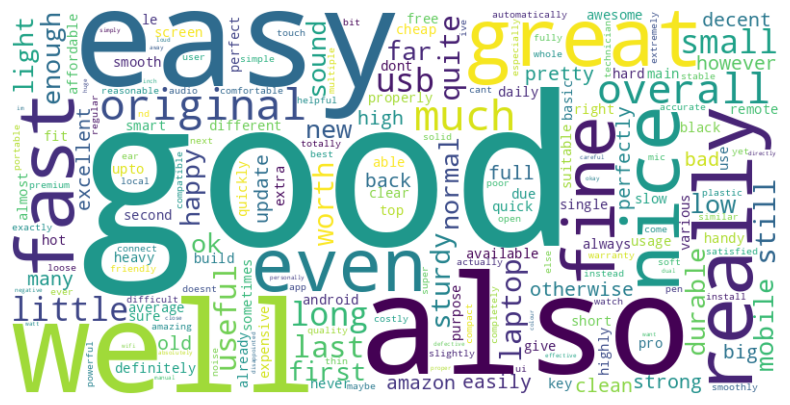

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract terms and their scores from the sorted DataFrame
terms = combined_df_sorted['Term'].tolist()
scores = combined_df_sorted['Combined Score'].tolist()

# Combine terms and scores into a dictionary
word_scores = {term: score for term, score in zip(terms, scores)}

# Create the WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


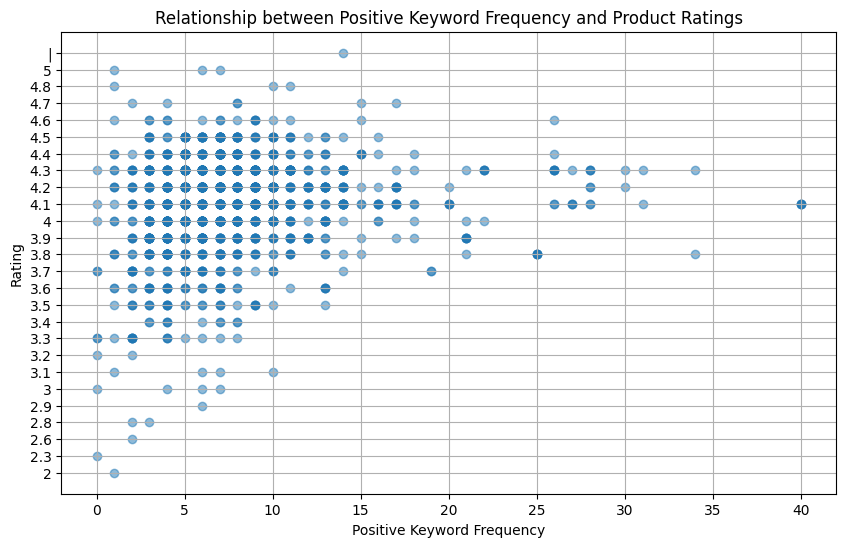

In [9]:
import pandas as pd

# Load the dataset
amazon_df = pd.read_csv("amazon.csv")

# Assuming you have the DataFrame df containing the positive terms and scores
# Replace this with your actual DataFrame containing positive terms and scores

# Sample data
data = {
    'Term': ['good', 'also', 'easy', 'well', 'great', 'really', 'nice', 'fast', 'even', 'fine'],
    'Combined Score': [0.112611, 0.036845, 0.035717, 0.030486, 0.026684, 0.026653, 0.025657, 0.025623, 0.022593, 0.021359]
}

df = pd.DataFrame(data)

# Filter out terms that are not considered positive sentiment
positive_terms = df[~df['Term'].isin(['also', 'really', 'even'])]['Term'].tolist()

# Function to calculate positive keyword frequency for each review
def calculate_positive_keyword_frequency(review):
    frequency = sum(review.lower().count(term.lower()) for term in positive_terms)
    return frequency

# Calculate positive keyword frequency for each review in the amazon_df DataFrame
amazon_df['Positive Keyword Frequency'] = amazon_df['review_content'].apply(calculate_positive_keyword_frequency)

# Sort the DataFrame by product_rating
amazon_df.sort_values(by='rating', inplace=True)

# Visualize the relationship between positive keyword frequency and product ratings
plt.figure(figsize=(10, 6))
plt.scatter(amazon_df['Positive Keyword Frequency'], amazon_df['rating'], alpha=0.5)
plt.title('Relationship between Positive Keyword Frequency and Product Ratings')
plt.xlabel('Positive Keyword Frequency')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


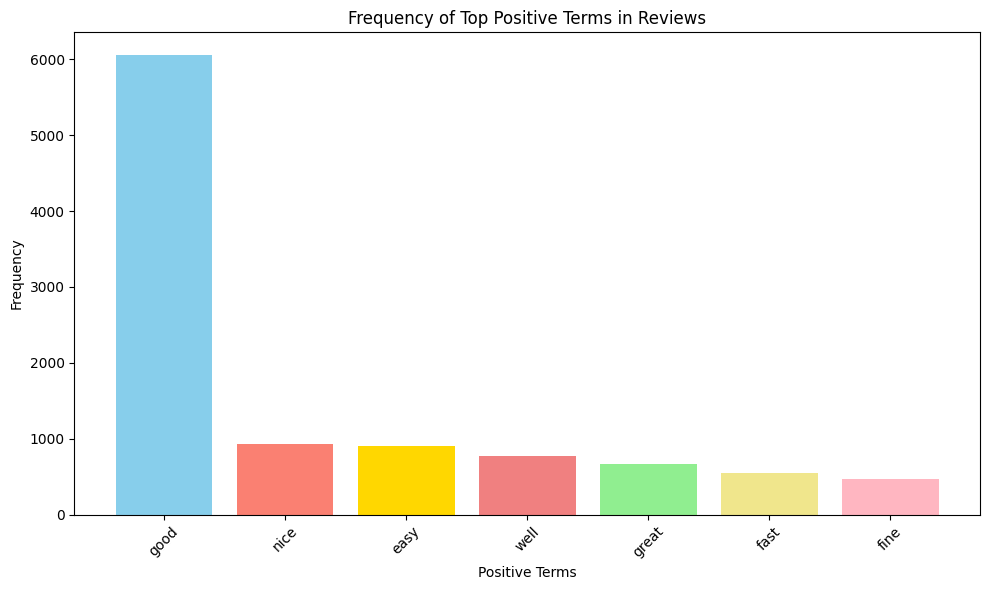

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

# Read the amazon.csv file into a DataFrame
amazon_df = pd.read_csv("amazon.csv")

# Extract the top 10 positive terms
top_positive_terms = [
    'good',  'easy', 'well', 'great',
     'nice', 'fast', 'fine'
]

# Initialize a dictionary to store the frequency of positive terms
term_frequency = {term: 0 for term in top_positive_terms}

# Tokenize and count the frequency of positive terms in the review_content column
for review in amazon_df['review_content']:
    tokens = word_tokenize(review.lower())
    for term in top_positive_terms:
        term_frequency[term] += tokens.count(term)

# Convert the dictionary to a DataFrame for visualization
frequency_df = pd.DataFrame(list(term_frequency.items()), columns=['Term', 'Frequency'])

# Sort the DataFrame by frequency in descending order
frequency_df = frequency_df.sort_values(by='Frequency', ascending=False)
colors = ['skyblue', 'salmon', 'gold', 'lightcoral',
          'lightgreen', 'khaki', 'lightpink']

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(frequency_df['Term'], frequency_df['Frequency'], color=colors)
plt.xlabel('Positive Terms')
plt.ylabel('Frequency')
plt.title('Frequency of Top Positive Terms in Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


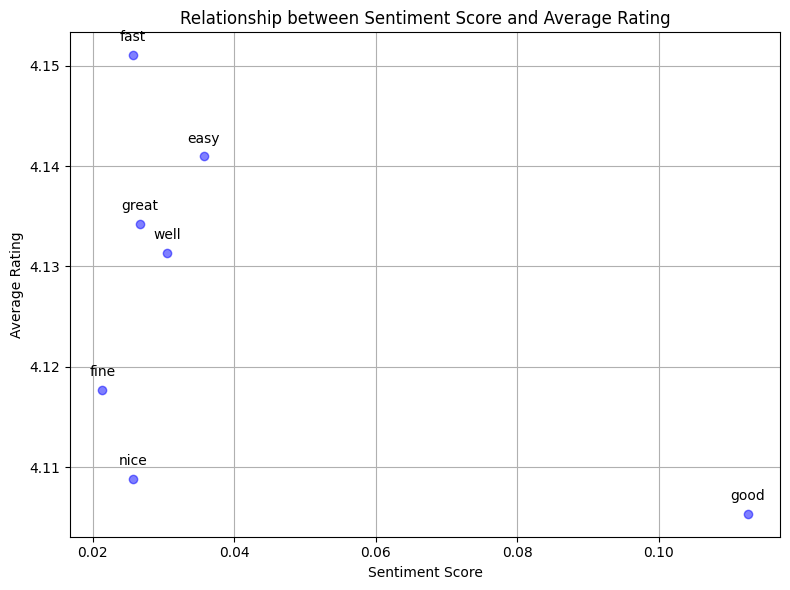

In [11]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(merged_df['Combined Score'], merged_df['Rating'], color='blue', alpha=0.5)
plt.title('Relationship between Sentiment Score and Average Rating')
plt.xlabel('Sentiment Score')
plt.ylabel('Average Rating')
plt.grid(True)

# Add annotations for each point
for i, txt in enumerate(merged_df['Term']):
    plt.annotate(txt, (merged_df['Combined Score'][i], merged_df['Rating'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()

